Deep Learning programming task

**Assignment 9:** 

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Aditya Dey : 230580 : aditya.dey@st.ovgu.de
3. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

In [59]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Activation,Add,Flatten,Dense,Input,ZeroPadding2D
from tensorflow.keras.models import Model
import keras.backend as K

In [61]:
from tensorflow.keras.initializers import glorot_uniform

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import os

In [64]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Assignment-9')

In [ ]:
import zipfile

In [ ]:
local_zip = "/content/drive/My Drive/Colab Notebooks/Assignment-9/cifar_attempts.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [75]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [76]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same',name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), padding='valid',name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid',name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    return X

In [77]:
def ResNet50(input_shape = (32, 32, 3), classes = 10):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7,7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # X = AveragePooling2D((1,1),name='avg_pool')(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# data1.npz

In [78]:
model = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [79]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [80]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [81]:
data_1 = np.load("data1.npz")

In [82]:
data_1.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

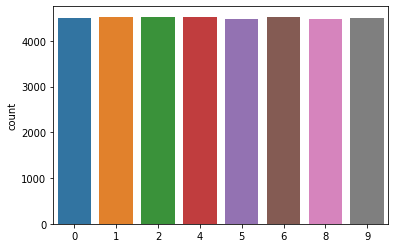

In [ ]:
sns.countplot(data_1['train_lbls'])

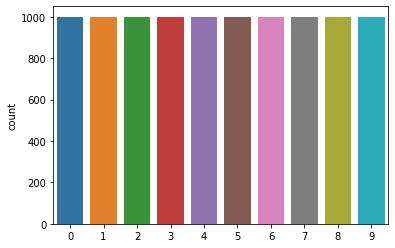

In [ ]:
sns.countplot(data_1['test_lbls'])

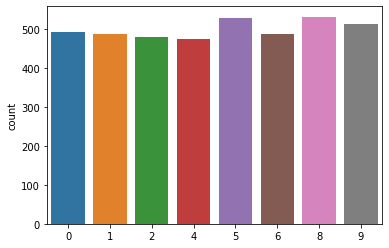

In [ ]:
sns.countplot(data_1['val_lbls'])

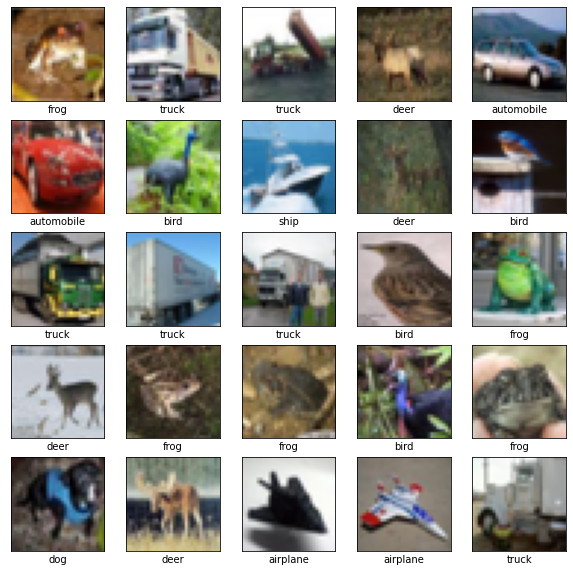

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_1['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_1['train_lbls'][i]])
plt.show()

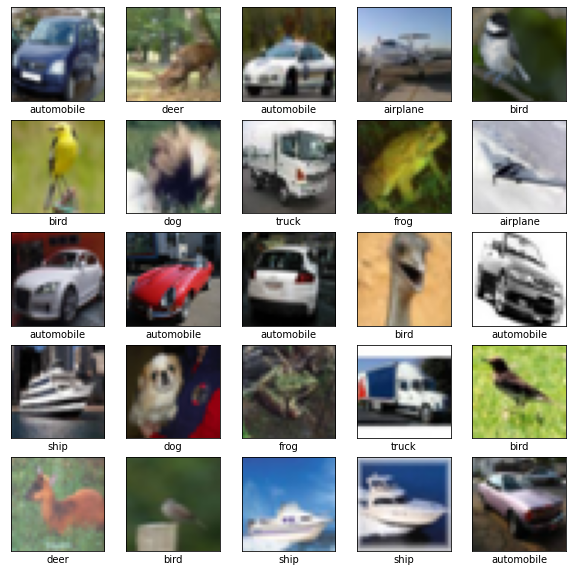

In [37]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_1['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_1['val_lbls'][i]])
plt.show()

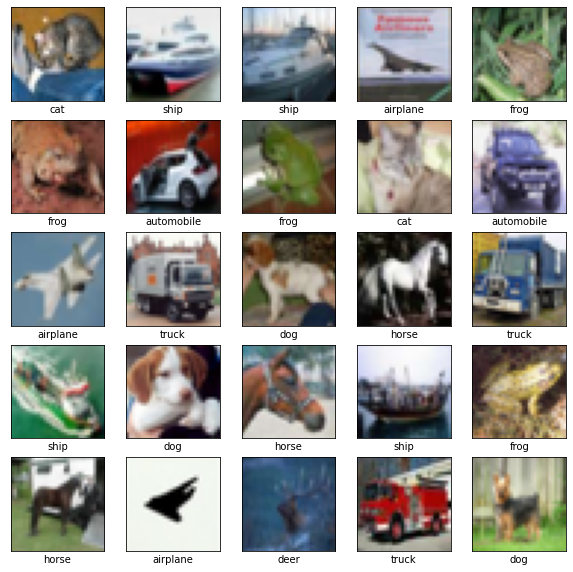

In [36]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_1['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_1['test_lbls'][i]])
plt.show()

In [83]:
X_train = data_1['train_imgs']/255.
X_test = data_1['test_imgs']/255.
X_validate = data_1['val_imgs']/255.

Y_train = tf.one_hot(data_1['train_lbls'], 10)
Y_test = tf.one_hot(data_1['test_lbls'], 10)
Y_validate = tf.one_hot(data_1['val_lbls'], 10)

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of validation examples = " + str(X_validate.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_validate shape: " + str(X_validate.shape))
print ("Y_validate shape: " + str(Y_validate.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 36004
number of test examples = 10000
number of validation examples = 3996
X_train shape: (36004, 32, 32, 3)
Y_train shape: (36004, 10)
X_validate shape: (3996, 32, 32, 3)
Y_validate shape: (3996, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [84]:
model.fit(X_train, Y_train, epochs = 10, batch_size = 128,validation_data=(X_validate,Y_validate),validation_batch_size=32)

Epoch 1/10
282/282 [==============================] - 47s 167ms/step - loss: 1.7479 - accuracy: 0.3985 - val_loss: 3.2914 - val_accuracy: 0.1221
Epoch 2/10
282/282 [==============================] - 45s 161ms/step - loss: 1.3630 - accuracy: 0.5165 - val_loss: 2.3888 - val_accuracy: 0.1737
Epoch 3/10
282/282 [==============================] - 45s 160ms/step - loss: 1.5500 - accuracy: 0.4892 - val_loss: 17.1101 - val_accuracy: 0.1634
Epoch 4/10
282/282 [==============================] - 45s 161ms/step - loss: 1.5442 - accuracy: 0.4422 - val_loss: 2.8494 - val_accuracy: 0.2538
Epoch 5/10
282/282 [==============================] - 45s 161ms/step - loss: 1.3229 - accuracy: 0.5487 - val_loss: 3.0473 - val_accuracy: 0.2182
Epoch 6/10
282/282 [==============================] - 45s 161ms/step - loss: 1.5474 - accuracy: 0.5118 - val_loss: 4.8189 - val_accuracy: 0.1459
Epoch 7/10
282/282 [==============================] - 45s 160ms/step - loss: 1.6700 - accuracy: 0.4825 - val_loss: 1.9640 - val_a

In [85]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 8s 25ms/step - loss: 4.5373 - accuracy: 0.2977
Loss = 4.537252902984619
Test Accuracy = 0.2976999878883362


**Conclusion**: Labeled images are missing for 3:Cat and 7:Horse in train and validation set but is present in test images.

# data2.npz

In [48]:
data_2 = np.load("data2.npz")

In [49]:
data_2.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

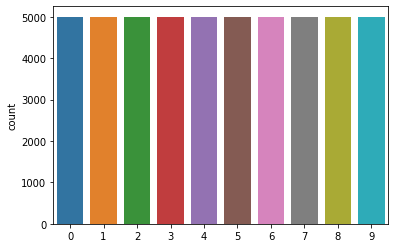

In [50]:
sns.countplot(data_2['train_lbls'])

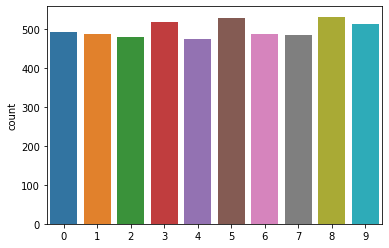

In [51]:
sns.countplot(data_2['val_lbls'])

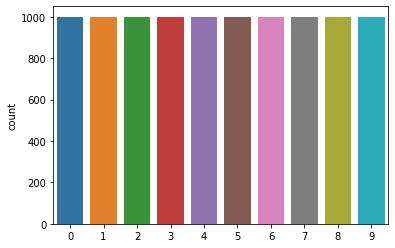

In [52]:
sns.countplot(data_2['test_lbls'])

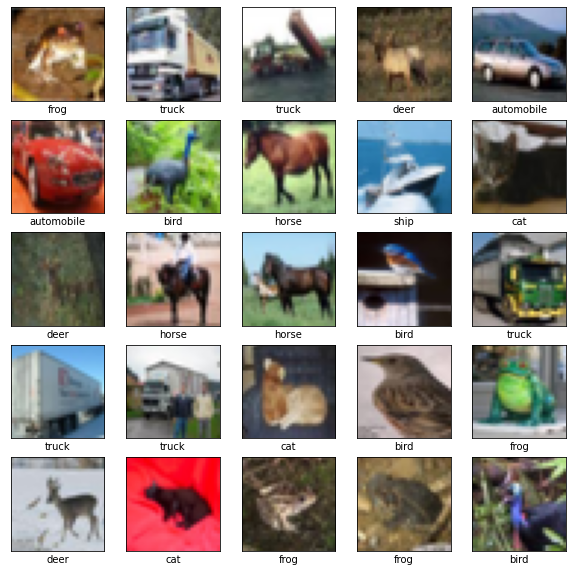

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['train_lbls'][i]])
plt.show()

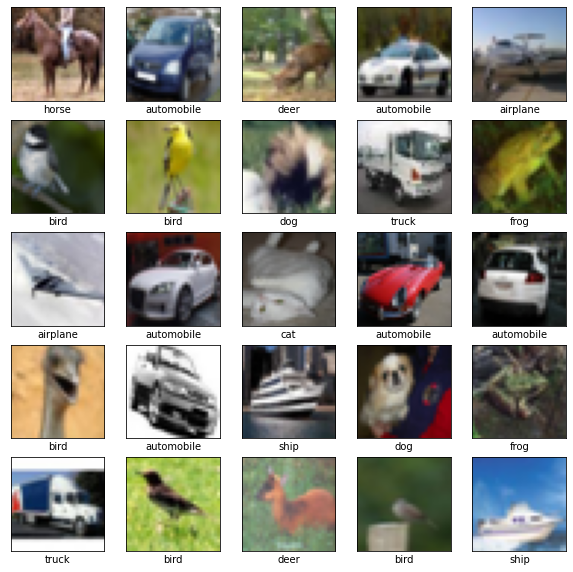

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['val_lbls'][i]])
plt.show()

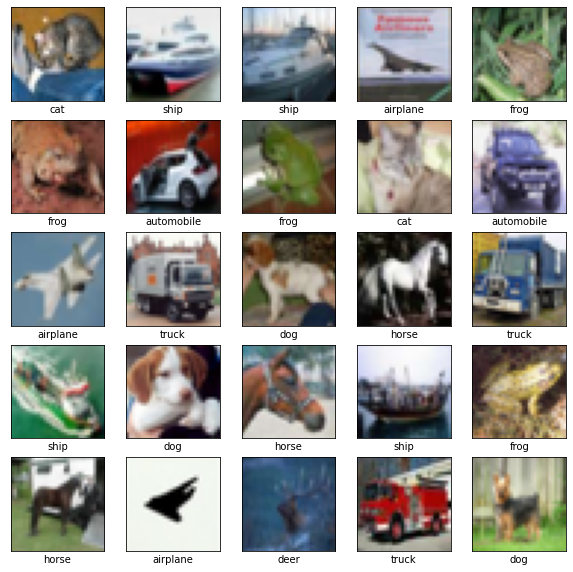

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_2['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['test_lbls'][i]])
plt.show()

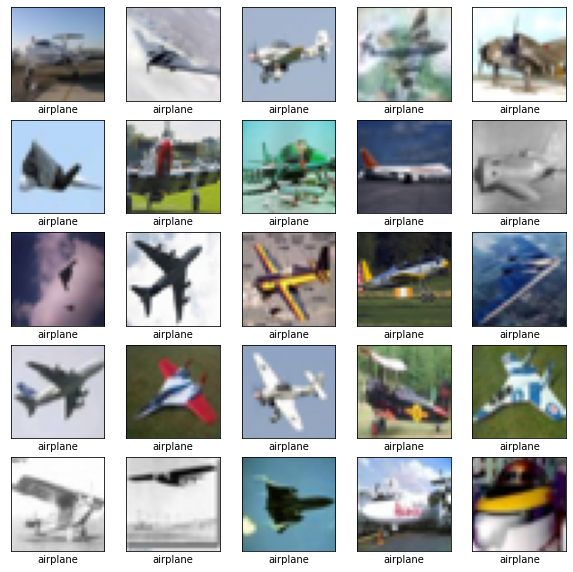

In [58]:
plt.figure(figsize=(10,10))
i = -1
for j in range(500):
  if(data_2['val_lbls'][j] == 0):
    i+=1
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_2['val_imgs'][j], cmap=plt.cm.binary)
    plt.xlabel(class_names[data_2['val_lbls'][j]])
    if(i==24):
      break
plt.show()

In [ ]:
X_train_2 = data_2['train_imgs']/255.
X_test_2 = data_2['test_imgs']/255.
X_validate_2 = data_2['val_imgs']/255.

Y_train_2 = tf.one_hot(data_2['train_lbls'], 10)
Y_test_2 = tf.one_hot(data_2['test_lbls'], 10)
Y_validate_2 = tf.one_hot(data_2['val_lbls'], 10)

print ("number of training examples = " + str(X_train_2.shape[0]))
print ("number of test examples = " + str(X_test_2.shape[0]))
print ("number of validation examples = " + str(X_validate_2.shape[0]))
print ("X_train_2 shape: " + str(X_train_2.shape))
print ("Y_train_2 shape: " + str(Y_train_2.shape))
print ("X_test_2 shape: " + str(X_test_2.shape))
print ("Y_test_2 shape: " + str(Y_test_2.shape))
print ("X_validate_2 shape: " + str(X_validate_2.shape))
print ("Y_validate_2 shape: " + str(Y_validate_2.shape))

number of training examples = 50000
number of test examples = 10000
number of validation examples = 5000
X_train_2 shape: (50000, 32, 32, 3)
Y_train_2 shape: (50000, 10)
X_test_2 shape: (10000, 32, 32, 3)
Y_test_2 shape: (10000, 10)
X_validate_2 shape: (5000, 32, 32, 3)
Y_validate_2 shape: (5000, 10)


In [ ]:
model_2 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2.fit(X_train_2, Y_train_2, epochs = 10, batch_size = 128,validation_data = (X_validate_2,Y_validate_2),validation_batch_size=32)

Epoch 1/10
391/391 [==============================] - 22s 57ms/step - loss: 1.9568 - accuracy: 0.3618 - val_loss: 3.0107 - val_accuracy: 0.0998
Epoch 2/10
391/391 [==============================] - 21s 54ms/step - loss: 1.7925 - accuracy: 0.4050 - val_loss: 535.9664 - val_accuracy: 0.1064
Epoch 3/10
391/391 [==============================] - 21s 53ms/step - loss: 1.6353 - accuracy: 0.4415 - val_loss: 2.2125 - val_accuracy: 0.2568
Epoch 4/10
391/391 [==============================] - 21s 54ms/step - loss: 1.4862 - accuracy: 0.5039 - val_loss: 1.8358 - val_accuracy: 0.3058
Epoch 5/10
391/391 [==============================] - 21s 53ms/step - loss: 1.6030 - accuracy: 0.5042 - val_loss: 16614.6426 - val_accuracy: 0.0958
Epoch 6/10
391/391 [==============================] - 21s 54ms/step - loss: 1.4702 - accuracy: 0.5109 - val_loss: 1.8703 - val_accuracy: 0.3524
Epoch 7/10
391/391 [==============================] - 21s 54ms/step - loss: 1.2976 - accuracy: 0.5671 - val_loss: 2.5685 - val_acc

In [ ]:
preds = model_2.evaluate(X_test_2, Y_test_2)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 2.4777 - accuracy: 0.2947
Loss = 2.4776556491851807
Test Accuracy = 0.2946999967098236


**Conclusion:** Class distribution is not even in Validation set as in Train and test.

# data3.npz

In [ ]:
data_3 = np.load("data3.npz")

In [ ]:
data_3.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [ ]:
X_train_3 = data_3['train_imgs']/255.
X_test_3 = data_3['test_imgs']/255.
X_validate_3 = data_3['val_imgs']/255.

Y_train_3 = tf.one_hot(data_3['train_lbls'], 10)
Y_test_3 = tf.one_hot(data_3['test_lbls'], 10)
Y_validate_3 = tf.one_hot(data_3['val_lbls'], 10)

print ("number of training examples = " + str(X_train_3.shape[0]))
print ("number of test examples = " + str(X_test_3.shape[0]))
print ("number of validation examples = " + str(X_validate_3.shape[0]))
print ("X_train_3 shape: " + str(X_train_3.shape))
print ("Y_train_3 shape: " + str(Y_train_3.shape))
print ("X_test_3 shape: " + str(X_test_3.shape))
print ("Y_test_3 shape: " + str(Y_test_3.shape))
print ("X_validate_3 shape: " + str(X_validate_3.shape))
print ("Y_validate_3 shape: " + str(Y_validate_3.shape))

number of training examples = 45000
number of test examples = 10000
number of validation examples = 5000
X_train_3 shape: (45000, 32, 32, 3)
Y_train_3 shape: (45000, 10)
X_test_3 shape: (10000, 32, 32, 3)
Y_test_3 shape: (10000, 10)
X_validate_3 shape: (5000, 32, 32, 3)
Y_validate_3 shape: (5000, 10)


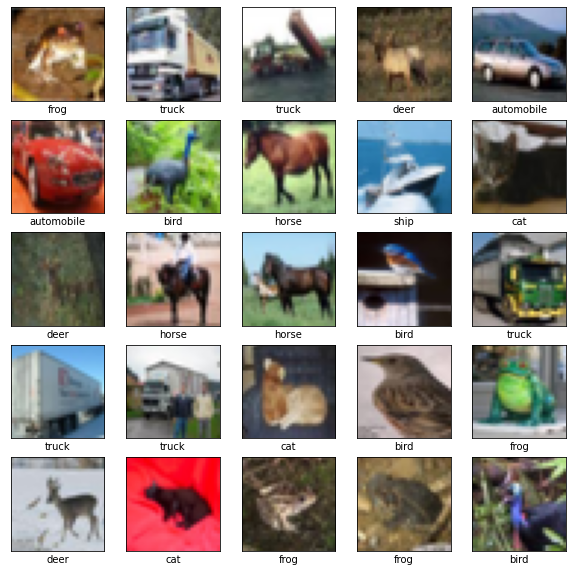

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_3['train_lbls'][i]])
plt.show()

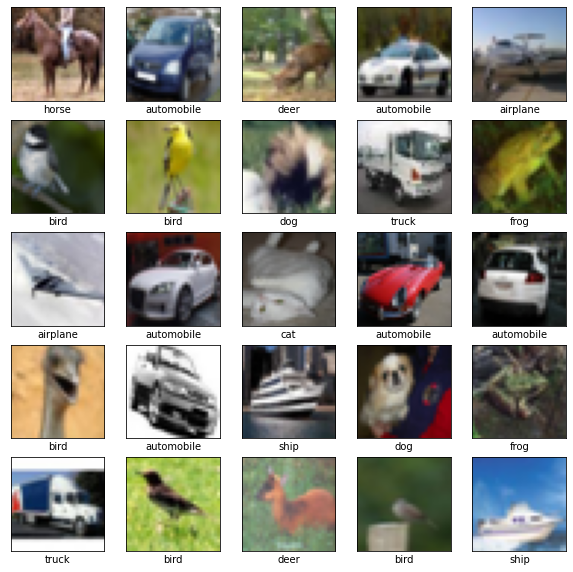

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_3['val_lbls'][i]])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

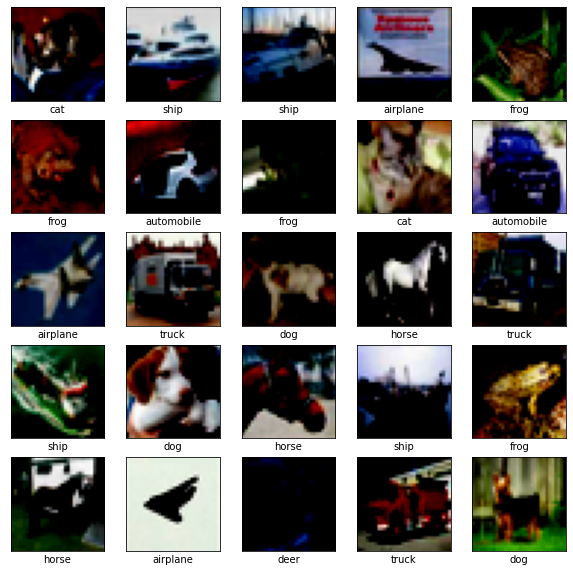

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_3['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_2['test_lbls'][i]])
plt.show()

In [ ]:
model_3 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_3.fit(X_train_3, Y_train_3, epochs = 10, batch_size = 128,validation_data = (X_validate_3,Y_validate_3),validation_batch_size=32)

Epoch 1/10
352/352 [==============================] - 20s 57ms/step - loss: 1.9979 - accuracy: 0.3480 - val_loss: 2.5732 - val_accuracy: 0.1220
Epoch 2/10
352/352 [==============================] - 19s 54ms/step - loss: 1.7784 - accuracy: 0.4311 - val_loss: 3433.1309 - val_accuracy: 0.0970
Epoch 3/10
352/352 [==============================] - 19s 54ms/step - loss: 1.8088 - accuracy: 0.4145 - val_loss: 14.3874 - val_accuracy: 0.1154
Epoch 4/10
352/352 [==============================] - 19s 54ms/step - loss: 1.7340 - accuracy: 0.4430 - val_loss: 3.8724 - val_accuracy: 0.1316
Epoch 5/10
352/352 [==============================] - 19s 54ms/step - loss: 1.5069 - accuracy: 0.4959 - val_loss: 96.2693 - val_accuracy: 0.1344
Epoch 6/10
352/352 [==============================] - 19s 54ms/step - loss: 1.4148 - accuracy: 0.5288 - val_loss: 7.5880 - val_accuracy: 0.0582
Epoch 7/10
352/352 [==============================] - 19s 54ms/step - loss: 1.3942 - accuracy: 0.5505 - val_loss: 5.1502 - val_accu

In [ ]:
preds = model_3.evaluate(X_test_3, Y_test_3)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 2.3747 - accuracy: 0.1155
Loss = 2.3747432231903076
Test Accuracy = 0.11550000309944153


**Conclusion**: Validation and test data are from different distribution. i.e from different sources. 

# data4.npz

In [9]:
data_4 = np.load("data4.npz")

In [10]:
data_4.files

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [11]:
X_train_4 = data_4['train_imgs']/255.
X_test_4 = data_4['test_imgs']/255.
X_validate_4 = data_4['val_imgs']/255.

Y_train_4 = tf.one_hot(data_4['train_lbls'], 10)
Y_test_4 = tf.one_hot(data_4['test_lbls'], 10)
Y_validate_4 = tf.one_hot(data_4['val_lbls'], 10)

print ("number of training examples = " + str(X_train_4.shape[0]))
print ("number of test examples = " + str(X_test_4.shape[0]))
print ("number of validation examples = " + str(X_validate_4.shape[0]))
print ("X_train_4 shape: " + str(X_train_4.shape))
print ("Y_train_4 shape: " + str(Y_train_4.shape))
print ("X_test_4 shape: " + str(X_test_4.shape))
print ("Y_test_4 shape: " + str(Y_test_4.shape))
print ("X_validate_4 shape: " + str(X_validate_4.shape))
print ("Y_validate_4 shape: " + str(Y_validate_4.shape))

number of training examples = 45000
number of test examples = 10000
number of validation examples = 5000
X_train_4 shape: (45000, 32, 32, 3)
Y_train_4 shape: (45000, 10)
X_test_4 shape: (10000, 32, 32, 3)
Y_test_4 shape: (10000, 10)
X_validate_4 shape: (5000, 32, 32, 3)
Y_validate_4 shape: (5000, 10)


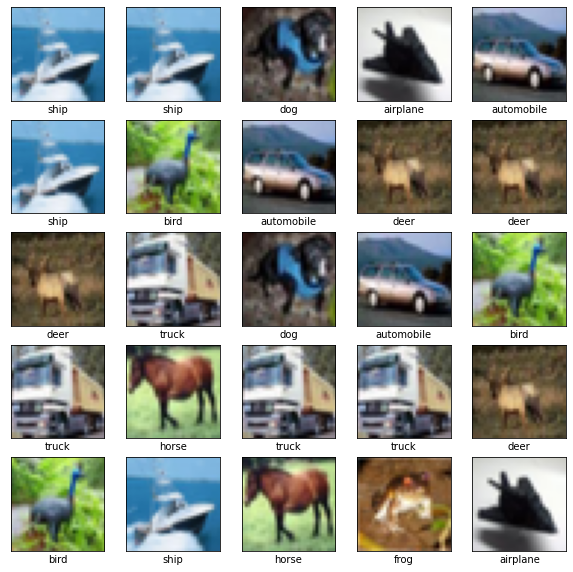

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['train_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['train_lbls'][i]])
plt.show()

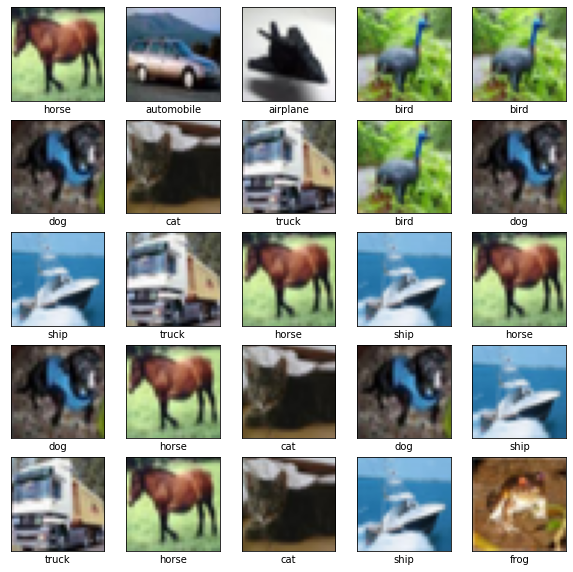

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['val_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['val_lbls'][i]])
plt.show()

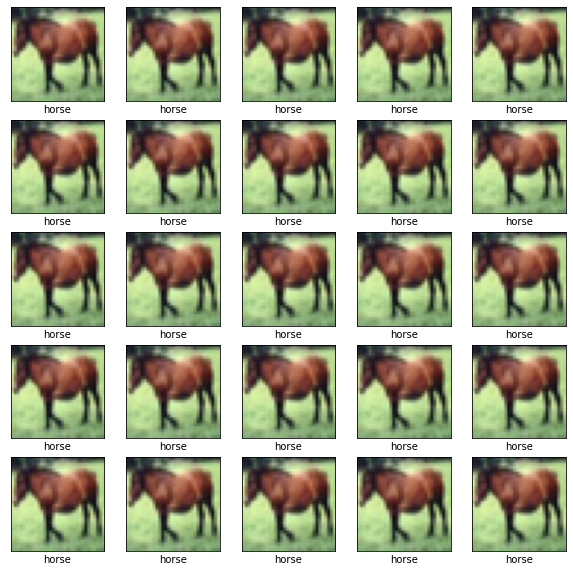

In [46]:
# Train Images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
i = -1
for j in range(500):
  if(data_4['train_lbls'][j] == 7):
    i+=1
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_4['train_imgs'][j], cmap=plt.cm.binary)
    plt.xlabel(class_names[data_4['train_lbls'][j]])
    if(i==24):
      break
plt.show()

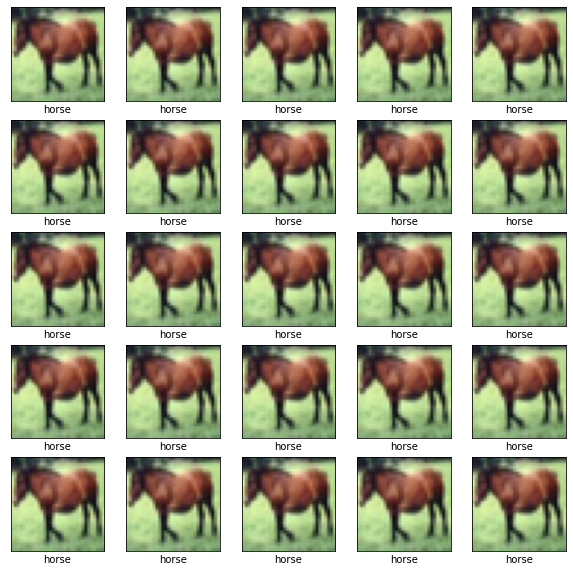

In [47]:
# Validation Images
plt.figure(figsize=(10,10))
i = -1
for j in range(500):
  if(data_4['val_lbls'][j] == 7):
    i+=1
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_4['val_imgs'][j], cmap=plt.cm.binary)
    plt.xlabel(class_names[data_4['val_lbls'][j]])
    if(i==24):
      break
plt.show()

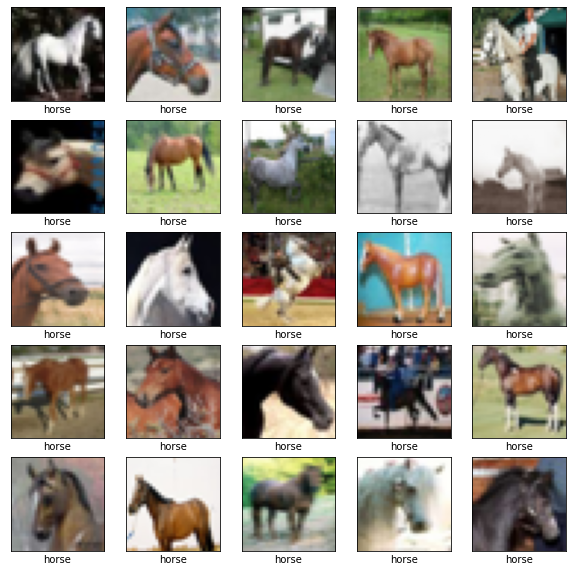

In [45]:
#Test Images
plt.figure(figsize=(10,10))
i = -1
for j in range(500):
  if(data_4['test_lbls'][j] == 7):
    i+=1
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data_4['test_imgs'][j], cmap=plt.cm.binary)
    plt.xlabel(class_names[data_4['test_lbls'][j]])
    if(i==24):
      break
plt.show()

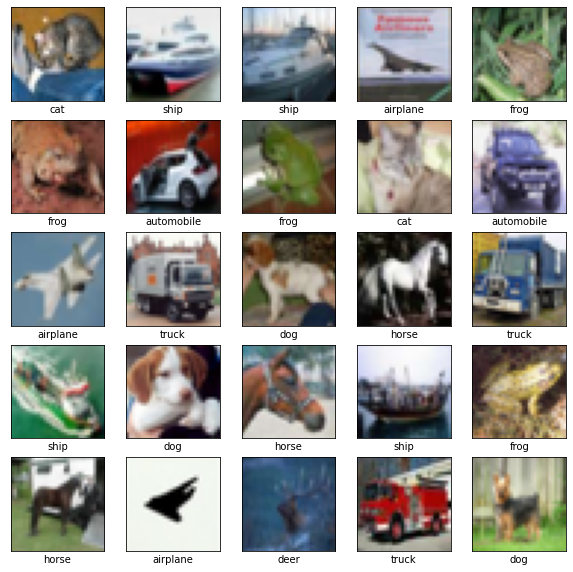

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_4['test_imgs'][i], cmap=plt.cm.binary)
  plt.xlabel(class_names[data_4['test_lbls'][i]])
plt.show()

In [ ]:
model_4 = ResNet50(input_shape = (32, 32, 3), classes = 10)

In [ ]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_4.fit(X_train_4, Y_train_4, epochs = 10, batch_size = 128,validation_data = (X_validate_4,Y_validate_4),validation_batch_size=32)

Epoch 1/10
352/352 [==============================] - 20s 56ms/step - loss: 0.0711 - accuracy: 0.9873 - val_loss: 16.8934 - val_accuracy: 0.1000
Epoch 2/10
352/352 [==============================] - 19s 54ms/step - loss: 2.7740e-06 - accuracy: 1.0000 - val_loss: 9.9846 - val_accuracy: 0.2000
Epoch 3/10
352/352 [==============================] - 19s 54ms/step - loss: 1.0435e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
352/352 [==============================] - 19s 54ms/step - loss: 9.6440e-08 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 5/10
352/352 [==============================] - 19s 55ms/step - loss: 4.2325e-07 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 6/10
352/352 [==============================] - 19s 54ms/step - loss: 1.3586e-07 - accuracy: 1.0000 - val_loss: 1.1921e-08 - val_accuracy: 1.0000
Epoch 7/10
352/352 [==============================] - 19s 54ms/step - loss: 0.1637 - accuracy: 0.97

In [ ]:
preds = model_4.evaluate(X_test_4, Y_test_4)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

313/313 [==============================] - 3s 11ms/step - loss: 24604.2695 - accuracy: 0.1000
Loss = 24604.26953125
Test Accuracy = 0.10000000149011612


**Conclusion:** In train and validation, Each label has the similar images. For example we could see of horse label where data is getting trained and tested on same image. But in test data for horse label, there are different images.

As a result we are geetting accuracy of 100% for train and validation set but 10% for test data